In [41]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from tqdm import tqdm
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [42]:
data_dir = "/kaggle/input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [43]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [44]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [45]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [46]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [47]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


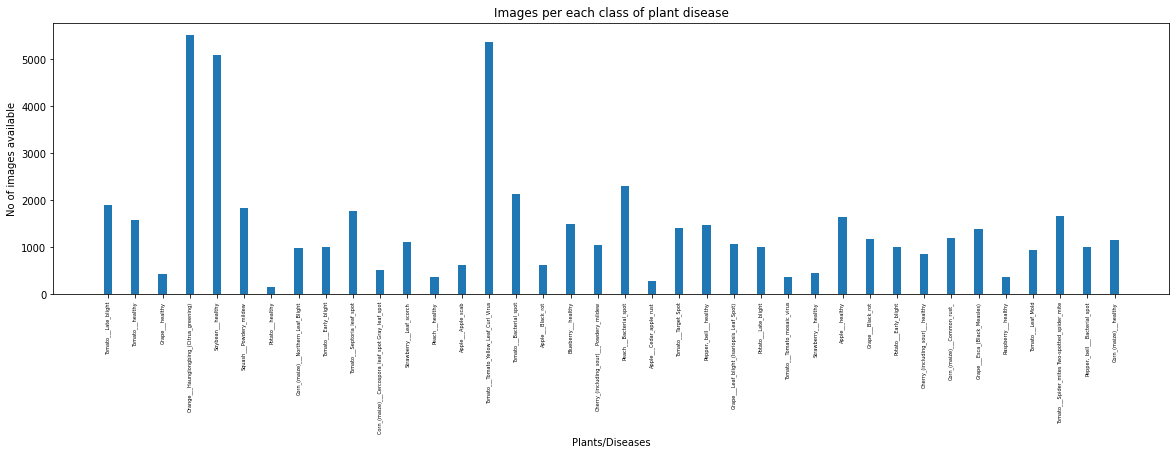

In [48]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

plt.savefig('/kaggle/working/ClassDistribution_PlantVillage_AfterOfflineAugmentation')

In [49]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            # transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
            transforms.Resize(224)
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [50]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [51]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 27


In [52]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

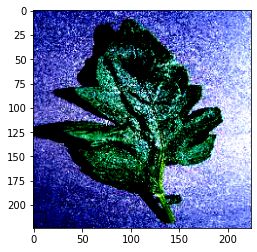

In [53]:
show_image(*train_dataset[21])

In [54]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [55]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

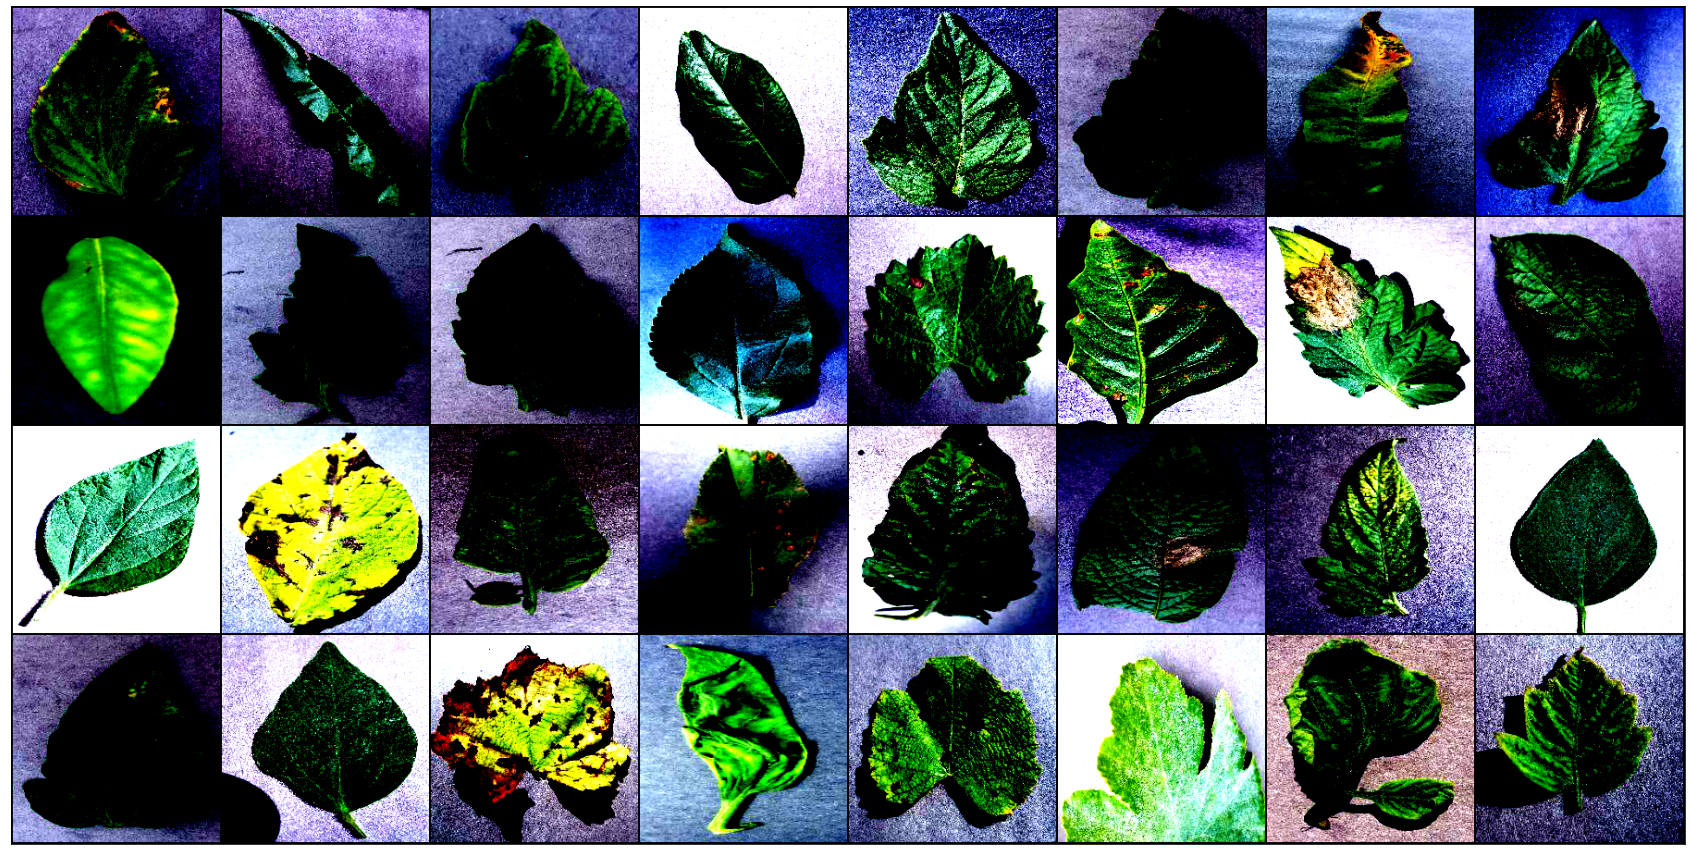

In [56]:
show_batch(train_dataloader)

In [57]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [58]:
# defining the model and moving it to the GPU

model_alexnet = models.alexnet(pretrained=True)

In [59]:
for param in model_alexnet.parameters():
    param.requires_grad = False

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, out_features=len(train_dataset.dataset.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alexnet.classifier[6].parameters(), lr=0.001)

Device: cuda:0


In [60]:
accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []


num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_alexnet(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_alexnet.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_alexnet(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = criterion(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/40], Step [100/1188], Loss: 0.3232, Accuracy: 87.50%
Epoch [1/40], Loss: 0.3280, Validation Accuracy: 83.94%
Epoch [1/40], Step [200/1188], Loss: 0.6218, Accuracy: 84.38%
Epoch [1/40], Loss: 0.1999, Validation Accuracy: 88.77%
Epoch [1/40], Step [300/1188], Loss: 0.4718, Accuracy: 78.12%
Epoch [1/40], Loss: 0.1255, Validation Accuracy: 90.31%
Epoch [1/40], Step [400/1188], Loss: 0.1744, Accuracy: 100.00%
Epoch [1/40], Loss: 0.2551, Validation Accuracy: 91.12%
Epoch [1/40], Step [500/1188], Loss: 0.3094, Accuracy: 93.75%
Epoch [1/40], Loss: 0.1964, Validation Accuracy: 92.78%
Epoch [1/40], Step [600/1188], Loss: 0.3893, Accuracy: 87.50%
Epoch [1/40], Loss: 0.0648, Validation Accuracy: 91.55%
Epoch [1/40], Step [700/1188], Loss: 0.4012, Accuracy: 87.50%
Epoch [1/40], Loss: 0.0908, Validation Accuracy: 92.73%
Epoch [1/40], Step [800/1188], Loss: 0.1081, Accuracy: 96.88%
Epoch [1/40], Loss: 0.0548, Validation Accuracy: 93.00%
Epoch [1/40], Step [900/1188], Loss: 0.1216, Accuracy: 

In [61]:
torch.save(model_alexnet, '/kaggle/working/Model_PlantVillage-AlexNet.pth')

# model = torch.load('model.pth')

In [62]:
print (accuracy_train)

[87.5, 84.375, 78.125, 100.0, 93.75, 87.5, 87.5, 96.875, 96.875, 90.625, 93.75, 96.875, 96.875, 96.875, 93.75, 100.0, 96.875, 93.75, 93.75, 93.75, 96.875, 93.75, 100.0, 100.0, 96.875, 96.875, 90.625, 96.875, 93.75, 100.0, 96.875, 96.875, 96.875, 90.625, 100.0, 96.875, 100.0, 100.0, 100.0, 100.0, 84.375, 96.875, 96.875, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 100.0, 93.75, 100.0, 100.0, 96.875, 100.0, 96.875, 93.75, 100.0, 100.0, 100.0, 93.75, 100.0, 100.0, 96.875, 100.0, 93.75, 96.875, 100.0, 93.75, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 100.0, 90.625, 96.875, 96.875, 96.875, 100.0, 96.875, 96.875, 100.0, 93.75, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 93.75, 93.75, 96.875, 100.0, 100.0, 93.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 93.75, 96.875, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 90.625, 100.0, 100.0, 100.0, 96.87

In [63]:
print (accuracy_validation)

[83.94106813996316, 88.76611418047882, 90.31307550644567, 91.12338858195211, 92.78084714548804, 91.54696132596685, 92.72559852670351, 93.00184162062615, 93.42541436464089, 93.38858195211786, 93.07550644567219, 93.59116022099447, 95.0828729281768, 94.25414364640883, 94.30939226519337, 94.41988950276243, 94.80662983425414, 93.6279926335175, 94.3830570902394, 93.77532228360957, 93.646408839779, 94.7145488029466, 94.82504604051566, 94.95395948434623, 94.5672191528545, 94.3646408839779, 94.65930018416206, 94.25414364640883, 94.5303867403315, 94.32780847145487, 94.65930018416206, 94.45672191528544, 95.06445672191528, 94.45672191528544, 95.2486187845304, 95.30386740331491, 95.65377532228361, 94.84346224677716, 96.09576427255986, 95.17495395948434, 95.2486187845304, 94.30939226519337, 94.08839779005524, 95.15653775322284, 94.9171270718232, 94.7329650092081, 95.4327808471455, 95.50644567219153, 95.39594843462247, 95.4327808471455, 94.5672191528545, 94.65930018416206, 95.19337016574586, 94.78821

In [64]:
print (loss_train)

[0.3231583833694458, 0.6218011379241943, 0.4717971384525299, 0.1743934452533722, 0.3094327747821808, 0.389325886964798, 0.4012471139431, 0.10805315524339676, 0.12161965668201447, 0.24738894402980804, 0.19682416319847107, 0.1554570347070694, 0.2657443881034851, 0.121798075735569, 0.2103647142648697, 0.07040157914161682, 0.10158105194568634, 0.11118156462907791, 0.27935990691185, 0.3887358605861664, 0.05576120316982269, 0.2253885120153427, 0.05260298028588295, 0.009488251060247421, 0.12439745664596558, 0.10924635827541351, 0.21369744837284088, 0.06119658797979355, 0.1464015394449234, 0.014013654552400112, 0.10244682431221008, 0.10469991713762283, 0.06370174139738083, 0.4643561840057373, 0.03416835144162178, 0.06635455787181854, 0.023088103160262108, 0.014972000382840633, 0.007987940683960915, 0.015611490234732628, 0.3545282483100891, 0.039451271295547485, 0.15735642611980438, 0.14360946416854858, 0.013868644833564758, 0.013127706944942474, 0.026508819311857224, 0.0027715275064110756, 0.0

In [65]:
print (loss_validation)

[0.3280082941055298, 0.1998693346977234, 0.12549230456352234, 0.2550525367259979, 0.19644011557102203, 0.06479047983884811, 0.09075871855020523, 0.05480164289474487, 0.09048166126012802, 0.1270071268081665, 0.0572640523314476, 0.019656961783766747, 0.08313178271055222, 0.09016275405883789, 0.04774080216884613, 0.19480198621749878, 0.03715335205197334, 0.16079150140285492, 0.09437107294797897, 0.028264010325074196, 0.24004970490932465, 0.02968825213611126, 0.01120765507221222, 0.14824551343917847, 0.09102866798639297, 0.2151603251695633, 0.005068302154541016, 0.03708450868725777, 0.020029155537486076, 0.03545582666993141, 0.05275704711675644, 0.2891094386577606, 0.009334526024758816, 0.027865994721651077, 0.044565968215465546, 0.03270932659506798, 0.00198435434140265, 0.1420859545469284, 0.16177774965763092, 0.08123639971017838, 0.10921924561262131, 0.21115635335445404, 0.22076715528964996, 0.045964788645505905, 0.33272719383239746, 0.1268632709980011, 0.09155557304620743, 0.07279862463

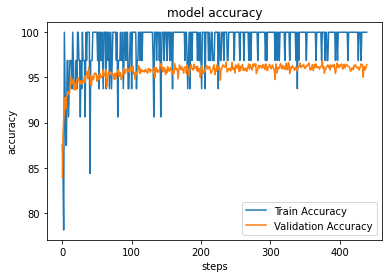

In [66]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_PlantVillage-AlexNet')
plt.show()

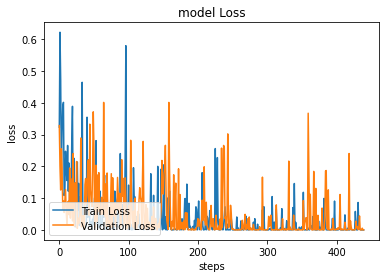

In [67]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="lower left")
plt.savefig('/kaggle/working/Loss_Plot_PlantVillage-AlexNet')
plt.show()

In [68]:
str(accuracy_train)

'[87.5, 84.375, 78.125, 100.0, 93.75, 87.5, 87.5, 96.875, 96.875, 90.625, 93.75, 96.875, 96.875, 96.875, 93.75, 100.0, 96.875, 93.75, 93.75, 93.75, 96.875, 93.75, 100.0, 100.0, 96.875, 96.875, 90.625, 96.875, 93.75, 100.0, 96.875, 96.875, 96.875, 90.625, 100.0, 96.875, 100.0, 100.0, 100.0, 100.0, 84.375, 96.875, 96.875, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 100.0, 93.75, 100.0, 100.0, 96.875, 100.0, 96.875, 93.75, 100.0, 100.0, 100.0, 93.75, 100.0, 100.0, 96.875, 100.0, 93.75, 96.875, 100.0, 93.75, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 100.0, 90.625, 96.875, 96.875, 96.875, 100.0, 96.875, 96.875, 100.0, 93.75, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 93.75, 93.75, 96.875, 100.0, 100.0, 93.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 93.75, 96.875, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 96.875, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.875, 90.625, 100.0, 100.0, 100.0, 96.8

In [69]:
str(accuracy_validation)

'[83.94106813996316, 88.76611418047882, 90.31307550644567, 91.12338858195211, 92.78084714548804, 91.54696132596685, 92.72559852670351, 93.00184162062615, 93.42541436464089, 93.38858195211786, 93.07550644567219, 93.59116022099447, 95.0828729281768, 94.25414364640883, 94.30939226519337, 94.41988950276243, 94.80662983425414, 93.6279926335175, 94.3830570902394, 93.77532228360957, 93.646408839779, 94.7145488029466, 94.82504604051566, 94.95395948434623, 94.5672191528545, 94.3646408839779, 94.65930018416206, 94.25414364640883, 94.5303867403315, 94.32780847145487, 94.65930018416206, 94.45672191528544, 95.06445672191528, 94.45672191528544, 95.2486187845304, 95.30386740331491, 95.65377532228361, 94.84346224677716, 96.09576427255986, 95.17495395948434, 95.2486187845304, 94.30939226519337, 94.08839779005524, 95.15653775322284, 94.9171270718232, 94.7329650092081, 95.4327808471455, 95.50644567219153, 95.39594843462247, 95.4327808471455, 94.5672191528545, 94.65930018416206, 95.19337016574586, 94.7882

In [70]:
str(loss_train)

'[0.3231583833694458, 0.6218011379241943, 0.4717971384525299, 0.1743934452533722, 0.3094327747821808, 0.389325886964798, 0.4012471139431, 0.10805315524339676, 0.12161965668201447, 0.24738894402980804, 0.19682416319847107, 0.1554570347070694, 0.2657443881034851, 0.121798075735569, 0.2103647142648697, 0.07040157914161682, 0.10158105194568634, 0.11118156462907791, 0.27935990691185, 0.3887358605861664, 0.05576120316982269, 0.2253885120153427, 0.05260298028588295, 0.009488251060247421, 0.12439745664596558, 0.10924635827541351, 0.21369744837284088, 0.06119658797979355, 0.1464015394449234, 0.014013654552400112, 0.10244682431221008, 0.10469991713762283, 0.06370174139738083, 0.4643561840057373, 0.03416835144162178, 0.06635455787181854, 0.023088103160262108, 0.014972000382840633, 0.007987940683960915, 0.015611490234732628, 0.3545282483100891, 0.039451271295547485, 0.15735642611980438, 0.14360946416854858, 0.013868644833564758, 0.013127706944942474, 0.026508819311857224, 0.0027715275064110756, 0.

In [71]:
str(loss_validation)

'[0.3280082941055298, 0.1998693346977234, 0.12549230456352234, 0.2550525367259979, 0.19644011557102203, 0.06479047983884811, 0.09075871855020523, 0.05480164289474487, 0.09048166126012802, 0.1270071268081665, 0.0572640523314476, 0.019656961783766747, 0.08313178271055222, 0.09016275405883789, 0.04774080216884613, 0.19480198621749878, 0.03715335205197334, 0.16079150140285492, 0.09437107294797897, 0.028264010325074196, 0.24004970490932465, 0.02968825213611126, 0.01120765507221222, 0.14824551343917847, 0.09102866798639297, 0.2151603251695633, 0.005068302154541016, 0.03708450868725777, 0.020029155537486076, 0.03545582666993141, 0.05275704711675644, 0.2891094386577606, 0.009334526024758816, 0.027865994721651077, 0.044565968215465546, 0.03270932659506798, 0.00198435434140265, 0.1420859545469284, 0.16177774965763092, 0.08123639971017838, 0.10921924561262131, 0.21115635335445404, 0.22076715528964996, 0.045964788645505905, 0.33272719383239746, 0.1268632709980011, 0.09155557304620743, 0.0727986246

In [72]:
model_alexnet.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_alexnet(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 96.08%


In [73]:
y_pred = []
y_true = []
features_tsne = None

model_alexnet.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_alexnet(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 95.95%


In [74]:
str(y_pred)

'[20, 29, 11, 35, 8, 26, 35, 26, 25, 35, 24, 34, 37, 4, 24, 30, 24, 24, 11, 37, 15, 25, 24, 15, 24, 24, 8, 11, 35, 23, 35, 25, 15, 30, 16, 12, 26, 33, 18, 8, 8, 24, 24, 15, 33, 17, 24, 15, 15, 28, 28, 15, 20, 15, 11, 20, 24, 30, 26, 37, 15, 13, 5, 25, 37, 35, 15, 13, 15, 24, 24, 35, 16, 15, 28, 28, 3, 15, 24, 37, 15, 8, 30, 35, 15, 35, 11, 16, 35, 6, 3, 9, 24, 10, 25, 35, 24, 31, 35, 28, 32, 23, 35, 10, 28, 13, 10, 24, 35, 24, 35, 12, 32, 34, 28, 28, 35, 8, 15, 32, 25, 16, 37, 17, 3, 8, 20, 37, 12, 27, 15, 15, 14, 19, 23, 14, 0, 28, 28, 16, 16, 3, 37, 28, 29, 15, 24, 5, 26, 5, 28, 1, 9, 26, 37, 15, 26, 33, 25, 26, 30, 35, 33, 35, 1, 35, 34, 27, 33, 11, 1, 4, 8, 8, 15, 24, 6, 36, 13, 15, 15, 33, 11, 24, 26, 34, 35, 25, 15, 30, 35, 37, 28, 23, 8, 24, 15, 12, 37, 15, 35, 32, 37, 9, 15, 21, 1, 15, 16, 2, 0, 31, 35, 3, 5, 31, 30, 29, 24, 32, 19, 37, 25, 10, 25, 37, 25, 1, 15, 15, 24, 15, 15, 24, 35, 28, 28, 34, 37, 10, 5, 15, 35, 4, 15, 15, 26, 24, 35, 24, 15, 9, 18, 13, 35, 5, 30, 4, 13, 1

In [75]:
str(y_true)

'[20, 29, 11, 35, 8, 26, 35, 26, 25, 35, 24, 29, 37, 4, 24, 30, 24, 24, 11, 37, 15, 25, 24, 15, 24, 24, 8, 11, 35, 23, 35, 25, 15, 30, 16, 12, 26, 34, 18, 8, 8, 24, 24, 15, 33, 17, 24, 15, 15, 29, 28, 15, 20, 15, 11, 20, 24, 30, 26, 37, 15, 13, 5, 25, 37, 35, 15, 13, 15, 24, 24, 35, 16, 15, 28, 28, 3, 15, 24, 37, 15, 8, 30, 35, 15, 35, 11, 16, 35, 6, 3, 9, 24, 10, 25, 35, 24, 31, 35, 28, 32, 23, 35, 10, 28, 13, 10, 24, 35, 24, 35, 12, 32, 34, 28, 28, 35, 8, 15, 32, 25, 16, 37, 17, 3, 8, 20, 37, 12, 27, 15, 15, 14, 19, 23, 14, 0, 28, 28, 16, 16, 3, 37, 29, 30, 15, 24, 5, 26, 5, 28, 1, 9, 26, 37, 15, 26, 33, 25, 26, 30, 35, 33, 35, 1, 35, 34, 27, 33, 11, 1, 4, 8, 8, 15, 24, 6, 36, 13, 15, 15, 33, 11, 24, 26, 34, 35, 25, 15, 30, 35, 37, 28, 23, 8, 24, 15, 12, 37, 15, 35, 32, 37, 9, 15, 21, 1, 15, 16, 2, 27, 31, 35, 3, 5, 31, 30, 29, 24, 32, 19, 37, 25, 10, 25, 37, 25, 1, 15, 15, 24, 15, 15, 24, 35, 3, 28, 29, 37, 10, 5, 15, 35, 4, 15, 15, 26, 24, 35, 24, 15, 9, 18, 13, 35, 5, 30, 4, 13, 1

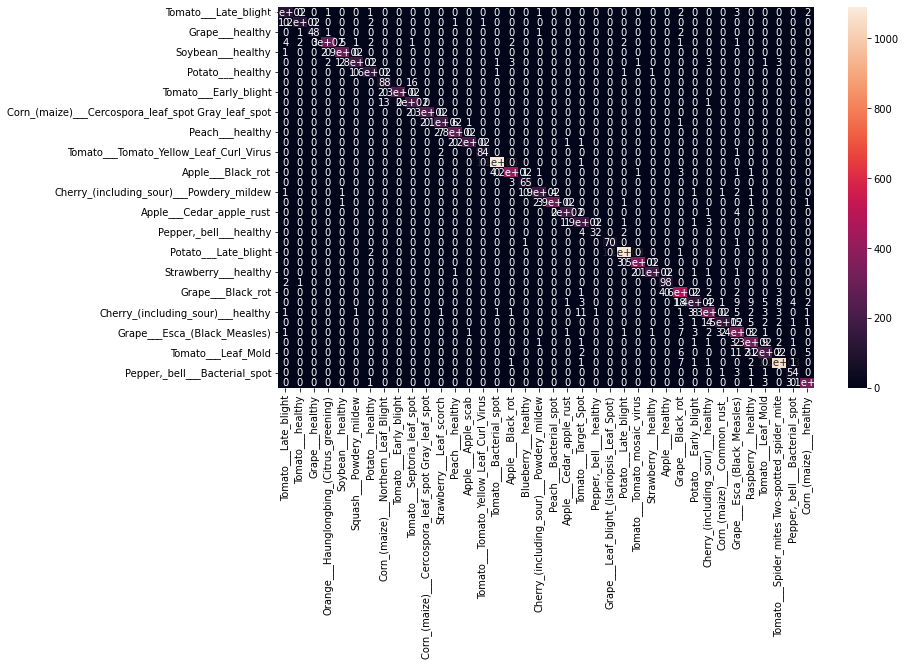

In [76]:
confusion_matrix_vec = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix_vec,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_PlantVillage-Alexnet.png')

In [77]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 95.95%
Precision: 96.02%
Sensitivity_recall: 95.95%
Specificity: 95.95%
F1 Score: 95.91%


In [78]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_PlantVillage-Alexnet')
    plt.show()

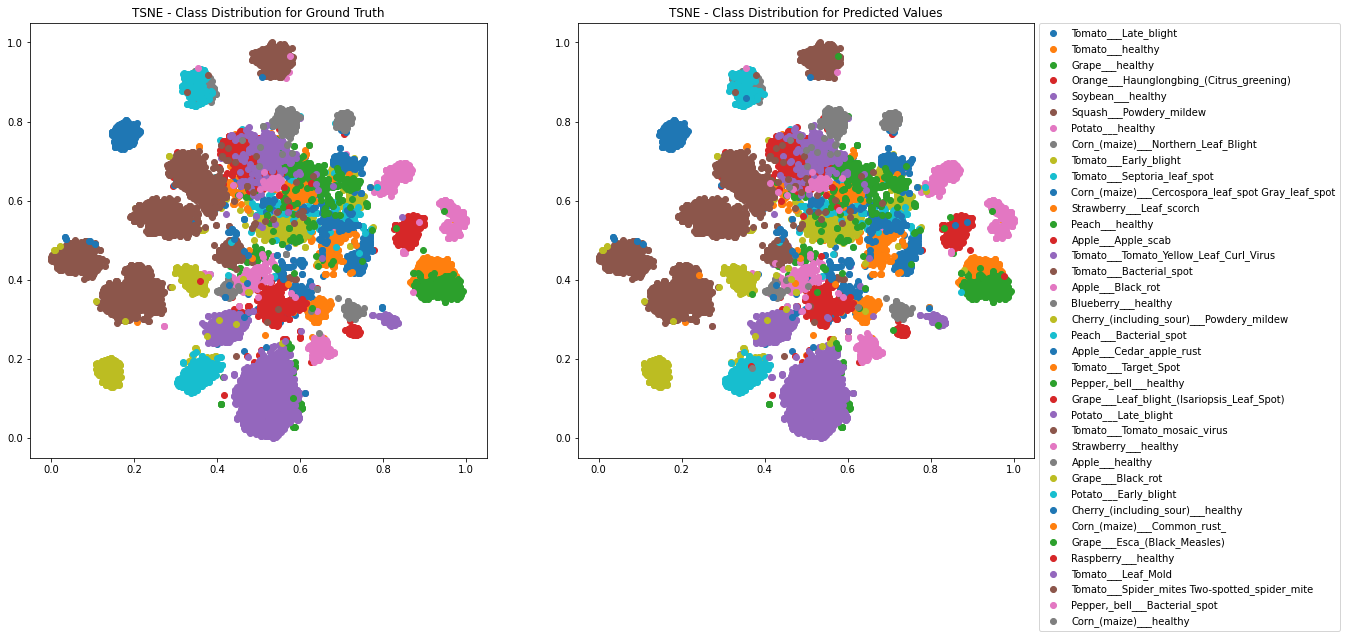

In [79]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')